Some $\LaTeX$ commands:
$$
\newcommand{\dd}{\mathrm{d}}
\newcommand{\diff}[2]{\frac{\dd #1}{\dd #2}}
$$

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

import sys

d = '/Users/wfarr/Research/CBCPopulation/O2Populations/code'
try:
    sys.path.index(d)
except ValueError:
    sys.path.append(d)
    
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
import h5py
from itertools import cycle
import multiprocessing as multi
import os
import vt
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d, RectBivariateSpline
from scipy.stats import gaussian_kde
import seaborn as sns
from tqdm import tqdm, tqdm_notebook

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

Populating the interactive namespace from numpy and matplotlib


This analysis is very similar to [Farr, et al. (2017)](https://ui.adsabs.harvard.edu/abs/2017Natur.548..426F/abstract), except that we are going to incorporate selection effects (since they are a strong function of mass).  For the latter, see [Mandel, Farr & Gair (2018)](https://ui.adsabs.harvard.edu/abs/2019MNRAS.tmp..870M/abstract) and references therein.

We have a (collection of) zero-parameter model(s) that predict the mass distribution of merging black holes (and, eventually, the redshift distribution).  We wish to compare them to gravitational wave data, $\mathbf{d}$, consisting of a catalog of detections, $i = 1, \ldots, N_\mathrm{det}$, each with data $d_i$; the catalog consists of events that pass a selection / detection threshold, which is why we need to incorporate selection effects.  The Bayseian posterior probability of model $M$ in this case is given by 
$$
p\left( M \mid \mathbf{d} \right) \propto p\left( \mathbf{d} \mid M \right) p\left( M \right).
$$
$p\left( \mathbf{d} \mid M \right)$ is sometimes known as the "Bayes factor;" it is the *likelihood* of model $M$ given the observed data.  $p(M)$ is the prior probability of model $M$, which we are free to assign based on our experience and intuition; in the absence of any good reason to do otherwise, it is common to take $p(M) \propto \mathrm{const}$.  (An example of a good reason to deviate from this might be if you produced a very large number of models with physically similar setups, and only a single model with an outlier setup---say 100 models of "field" binary formation with differing parameters and a single "cluster" model---then you might want to weight the two *classes* equally, and then each model w/i class equally.)

To compute $p\left( \mathbf{d} \mid M \right)$, we usually assume that the likelihoods of the individual events are independent (this is appropriate as long as the noise surrounding each event is independent, which is what we see in LIGO).  Under this assumption,
$$
p\left( \mathbf{d} \mid M \right) = \prod_{i=1}^{N_\mathrm{det}} p\left( d_i \mid M \right).
$$
Each model makes predictions about the masses of the merging binaries (we are, for the moment, ignoring the merger redshifts/lookback times that are predicted and instead imposing a fixed merger rate distribution, though we can incorporate them later).  The GW likelihood depends on these masses, so we have 
$$
p\left( d_i \mid M \right) = \frac{\int \, \dd m_1 \, \dd m_2 \, \dd z \, p\left( d_i \mid m_1, m_2 \right) p\left( m_1, m_2 \mid M \right)}{\int \, \dd m_1 \, \dd m_2 \, \dd z \, P_\mathrm{det}\left( m_1, m_2, z \right) p\left( m_1, m_2 \mid M \right) p\left( z \mid M \right)};
$$
here the numerator is the likelihood of the LIGO data given the masses predicted by the model $M$, and the denominator is the correction for the selection function and gives the average detectability (fraction of detected events) for the model population.

The denominator is independent of the data, $d_i$, and common to all events.  It can be pre-computed, most easily via Monte-Carlo: we will assign a redshift randomly to your set of events, calculate $P_\mathrm{det}$ following [Abbott, et al. (2016)](https://ui.adsabs.harvard.edu/abs/2016ApJS..227...14A/abstract), and average.

The numerator can also be computed via Monte-Carlo using parameter estimation samples from [Abbott, et al. (2018)](https://ui.adsabs.harvard.edu/abs/2018arXiv181112907T/abstract).  Those are drawn from a posterior density that incorporates the likelihood and a prior, $p_\mathrm{PE}\left( m_1, m_2, z \right)$:
$$
m_1, m_2, z \sim p\left( d_i \mid m_1, m_2, z \right) p_\mathrm{PE} \left( m_1, m_2, z \right),
$$
so the likelihood integral that we need can be computed via 
$$
\int \, \dd m_1 \, \dd m_2 \, \dd z \, p\left( d_i \mid m_1, m_2, z \right) p\left( m_1, m_2, z \mid M \right) = \int \, \dd m_1 \, \dd m_2 \, \dd z \, p\left( d_i \mid m_1, m_2, z \right) p_\mathrm{PE}\left( m_1, m_2, z \right) \frac{p\left( m_1, m_2, z \mid M \right)}{p_\mathrm{PE}\left( m_1, m_2, z \right)} \propto \left\langle \frac{p\left( m_1, m_2, z \mid M \right)}{p_\mathrm{PE}\left( m_1, m_2, z \right)} \right\rangle,
$$
where the final average is taken over the PE samples.  The PE prior is uniform in the *detector-frame* masses and proportional to $d_L^2$, so in *source-frame* masses and redshift, it is 
$$
p_\mathrm{PE} \left( m_1, m_2, z \right) \propto \left( 1 + z \right)^2 d_L^2 \diff{d_L}{z}
$$

The final choice is in how we compute $p\left( m_1 , m_2 , z \mid M \right)$.  The redshift distribution we are imposing is analytic, with 
$$
p\left( z \right) \propto \diff{V}{z} \left( 1 + z \right)^{\lambda - 1},
$$
with $\lambda = 0$ giving constant merger rate in the comoving frame and $\lambda \simeq 3$ tracking the star formation rate.  For the mass distribution, I implement a KDE in a unconstrained parameter space, $(x,y)$, defined by 
$$
x = \log m_1
$$
and
$$
y = \log m_2 - \log \left( m_1 - m_2 \right),
$$
whence
$$
p\left( m_1, m_2, z \mid M \right) \propto \diff{V}{z} \left( 1 + z \right)^{\lambda - 1} \mathrm{KDE}\left( x, y \right) \frac{1}{m_1} \left( \frac{1}{m_2} + \frac{1}{m_1 - m_2} \right).
$$

The following cells implement bits of this calculation.

In [2]:
def make_kde(m1, m2):
    mh = where(m1 > m2, m1, m2)
    ml = where(m1 > m2, m2, m1)
    
    x = log(mh)
    y = log(ml) - log(mh-ml)
    
    return gaussian_kde(row_stack((x, y)))

def make_zdist(l, zmax):
    zs = expm1(linspace(0, log(zmax+1), 1000))
    pz = Planck15.differential_comoving_volume(zs).to(u.Gpc**3/u.sr).value * (1+zs)**(l-1)
    norm = trapz(pz, zs)
    pz /= norm
    
    return interp1d(zs, pz)

def p_pe(m1, m2, z):
    return (1+z)**2*Planck15.luminosity_distance(z).to(u.Gpc).value**2*(Planck15.comoving_distance(z).to(u.Gpc).value + (1+z)*Planck15.hubble_distance.to(u.Gpc).value/Planck15.efunc(z))

def make_pm1m2z(m1, m2, l, zmax):
    k = make_kde(m1, m2)
    zd = make_zdist(l, zmax)
    
    def pm1m2z(m1, m2, z):
        pz = zd(z)
        x = log(m1)
        y = log(m2) - log(m1-m2)
        pk = k(row_stack((x, y)))
        
        return pz*pk/m1*(1/m2 + 1/(m1-m2))
    
    return pm1m2z

Before we do anything else, let's set up a grid in *detector* mass giving the optimal SNR at $1 \, \mathrm{Gpc}$; this will let us interpolate to find the optimal SNR at any mass and distance (since $\rho$ scales as $1/d_L$ at fixed detector frame mass).

This cell saves its results to an HDF5 file (it takes a few minutes to run); the next cell loads the file and constructs the optimal SNR calculator, and can be executed without re-generating the optimal SNR grid.

In [4]:
z1gpc = cosmo.z_at_value(Planck15.luminosity_distance, 1*u.Gpc)

ms = exp(linspace(log(1), log(100), 100))
M1S, M2S = meshgrid(ms, ms, indexing='ij')
def osm1m2(m1m2):
    m1, m2 = m1m2
    m1s = m1/(1+z1gpc)
    m2s = m2/(1+z1gpc)
    
    return vt.optimal_snr(m1s, m2s, z1gpc)

pool = multi.Pool()
try:
    OSS = array(list(tqdm_notebook(pool.imap(osm1m2, zip(M1S.ravel(), M2S.ravel())), total=len(M1S.ravel()))))
    OSS = reshape(OSS, M1S.shape)
finally:
    pool.close()
    
with h5py.File('optimal_snr.h5', 'w') as out:
    out.create_dataset('ms', data=ms, compression='gzip', shuffle=True)
    out.create_dataset('osnrs', data=OSS, compression='gzip', shuffle=True)

In [5]:
with h5py.File('optimal_snr.h5', 'r') as f:
    ms = array(f['ms'])
    OSS = array(f['osnrs'])

M1S, M2S = meshgrid(ms, ms, indexing='ij')

oint = RectBivariateSpline(ms, ms, OSS)

def optimal_snr(m1, m2, z):
    m1d = m1*(1+z)
    m2d = m2*(1+z)
    
    dl = Planck15.luminosity_distance(z).to(u.Gpc).value
    
    return oint.ev(m1d, m2d)/dl

In [6]:
optimal_snr(5,5,0.6), vt.optimal_snr(5,5,0.6)

(1.5204462121427074, 1.5204461453759621)

I grabbed the posterior sample files from https://dcc.ligo.org/LIGO-P1800370/public; here we load them up:

In [7]:
postsamples = {}
z = expm1(linspace(0, log(4), 1000))
d = Planck15.luminosity_distance(z).to(u.Mpc).value
z_of_d = interp1d(d, z)
for f in tqdm_notebook(os.listdir('GWTC-1_sample_release')):
    name = f[:8]
    with h5py.File(os.path.join('GWTC-1_sample_release', f), 'r') as f:
        dl = array(f['Overall_posterior']['luminosity_distance_Mpc'])
        z = z_of_d(dl)
        m1 = array(f['Overall_posterior']['m1_detector_frame_Msun'])/(1+z)
        m2 = array(f['Overall_posterior']['m2_detector_frame_Msun'])/(1+z)
        
        postsamples[name] = (m1, m2, z)

Here we load the data from Yihan's cluster runs.

In [8]:
clusters = {}
for a in tqdm_notebook([0, 1, 2, 2.35, 3, 4]):
    c = loadtxt('Clusters/small_cluster_{:g}.dat'.format(a), dtype=np.dtype([('m1', np.float), ('m2', np.float), ('a', np.float), ('e', np.float), ('tgw', np.float)]))
    clusters[a] = c[c['tgw'] < 1e10]

We need to have a redshift distribution over all the possible samples we have from PE.  We also need to make sure that $P_\mathrm{det}\left( z_\mathrm{max} \right) = 0$.  In fact, the posterior on redshift for GW170729 extends past the GW detection horizon for the selection function we are using; this tells us that the selection function is wrong, but we have checked whether this makes a difference for our analyses in LIGO (we use the same approximation sometimes), and it doesn't seem to.

In [9]:
zMax = 1.1*max(*[np.max(p[2]) for p in postsamples.values()])
print('zMax = {:.2f}'.format(zMax))

zMax = 0.99


Set this to $\lambda = 0$ for constant merger rate in the comoving frame; $\lambda = 3$ for something that roughly tracks the SFR.

In [10]:
lam = 0

The computation of the average detectability is a bit tricky.  We follow [Farr (2019, in prep)](https://github.com/farr/SelectionAccuracy) and draw a sample of detected systems according to a simple distribution, $p_\mathrm{draw}$; then by the basic rules of Monte-Carlo integration the denominator in the likelihood is given by 
$$
\left \langle P_\mathrm{det} \right\rangle = \left\langle \frac{p\left( m_1, m_2 \mid M \right) p\left( z \mid M \right) }{p_\mathrm{draw}\left( m_1, m_2, z \right)} \right\rangle_{\left\{ m_1, m_2, z \in \mathrm{draws} \right\}}.
$$
(We actually use a correction to the formula that incorporates the leading-order finite-$N$ effect; see Farr (2019) above.)

We can also estimate the Monte-Carlo uncertainty in the integral; Farr (2019) shows that we get reliable parameter estimates as long as 
$$
\frac{\left\langle P^2_\mathrm{det} \right\rangle}{\sigma^2_{P_\mathrm{det}}} \equiv N_\mathrm{eff} \gg 4 N_\mathrm{det} = 40.
$$

The number of draws is chosen to ensure that $N_\mathrm{eff} \gtrsim 2 \times 4 N_\mathrm{det} \simeq 80$ with the distribution of masses and redshifts we have chosen.

In [54]:
Ndraw = 0
Ndesired = 50000

MMin = 1
MMax = 100

snr_thresh = 8

m1_det = []
m2_det = []
z_det = []
wt_det = []

with tqdm_notebook(total=Ndesired) as bar:
    while len(m1_det) < Ndesired:
        m1 = exp(log(MMin) + log(MMax/MMin)*rand())  # Flat in log(m1)
        m2 = MMin + (m1 - MMin)*rand()  # Flat from MMin to m1
        z = expm1(log(1) + log((1+zMax)/1)*rand()) # Flat in log(1+z)
                
        Ndraw += 1
        
        rho_true = random.choice(vt.thetas)*optimal_snr(m1, m2, z)
        rho = rho_true + randn()
        
        if rho > snr_thresh:
            # These need to be normalized or else the integral does not compute <Pdet> (though it would still work)
            pm1 = 1.0/(m1*log(MMax/MMin))  
            pm2 = 1.0/(m1 - MMin)
            pz = 1.0/((1+z)*log((1+zMax)/1))
            
            m1_det.append(m1)
            m2_det.append(m2)
            z_det.append(z)
            wt_det.append(pm1*pm2*pz)
            
            bar.update(1)
            
m1_det = array(m1_det)
m2_det = array(m2_det)
z_det = array(z_det)
wt_det = array(wt_det)

Here we compute the average detection probability for each of the cluster populations:

In [55]:
def mean_pdet(m1, m2, lam, zMax):
    pm1m2z = make_pm1m2z(m1, m2, lam, zMax)
    
    pds = pm1m2z(m1_det, m2_det, z_det) / wt_det
    
    mu = np.sum(pds)/Ndraw
    sigma2 = pds.shape[0]*np.var(pds)/Ndraw**2
    
    Neff = mu*mu/sigma2
    
    return mu, Neff

In [56]:
mean_pdets = {}
for k, c in tqdm_notebook(clusters.items()):
    mean_pdets[k] = mean_pdet(c['m1'], c['m2'], lam, zMax)
    mu, N = mean_pdets[k]
    print('For slope {:g} <Pdet> = {:g} and Neff = {:g}'.format(k, mu, N))

For slope 0 <Pdet> = 0.0176834 and Neff = 2126.33
For slope 1 <Pdet> = 0.0106852 and Neff = 4061.27
For slope 2 <Pdet> = 0.00559553 and Neff = 6576.72
For slope 2.35 <Pdet> = 0.00464301 and Neff = 6992.43
For slope 3 <Pdet> = 0.00233223 and Neff = 5479.5
For slope 4 <Pdet> = 0.00128759 and Neff = 2772.71



And here we compute the log-probability (evidence) for each cluster population; c.f. formulas above.

In [57]:
Nobs = len(postsamples.values())

logevs = {}
for k, c in tqdm_notebook(clusters.items()):
    mu, Neff = mean_pdets[k]
    pm1m2z = make_pm1m2z(c['m1'], c['m2'], lam, zMax)
    log_ev = 0.0
    for e in tqdm_notebook(postsamples.values()):
        log_ev += log(mean(pm1m2z(*e)/p_pe(*e)))
    logevs[k] = log_ev - Nobs*log(mu) + (3*Nobs + Nobs*Nobs)/(2*Neff)

Evidence values are not defined on an absolute scale, but only up to a constant.  Here we normalize the evidence values so that the integral over $\alpha$ is one (thus one can interpret a plot of the evidence values versus $\alpha$ as a *density* or PDF for $\alpha$).  We first re-scale by the largest evidence value (to avoid overflow in the exponential), and then do a trapezoidal integral.

In [58]:
Zm = max(*logevs.values())
for k in logevs.keys():
    logevs[k] = logevs[k] - Zm

In [59]:
Ztot = trapz(exp(list(logevs.values())), list(logevs.keys()))
for k in logevs.keys():
    logevs[k] = logevs[k] - log(Ztot)

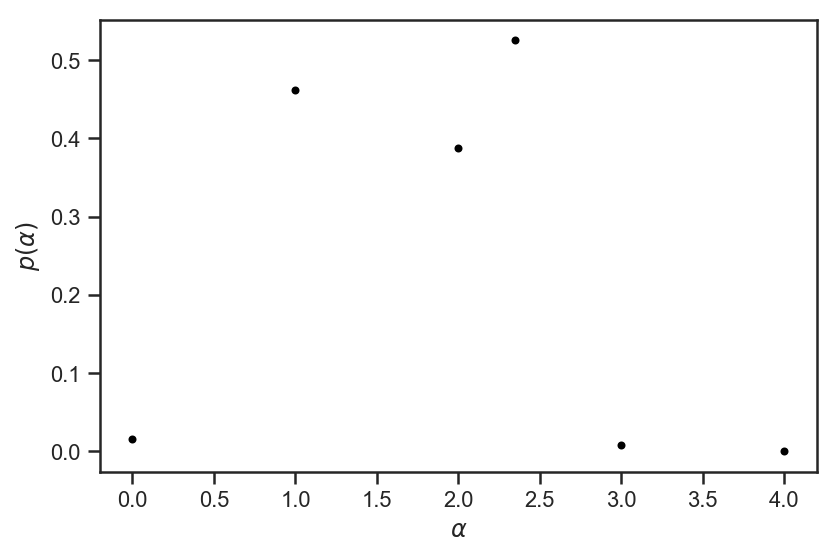

In [60]:
plot(list(logevs.keys()), exp(list(logevs.values())), '.k')

xlabel(r'$\alpha$')
ylabel(r'$p\left( \alpha \right)$')

tight_layout()
savefig('alpha.pdf')

Here we plot the observed distribution of total mass against the distributions from each of the populations.  **Note** this is not a fair comparison because we are comparing *observed* properties (i.e. passed through a selection function and also convolved with observational errors) against *intrinsic* properties (the mass distributions).  See below for a fair comparison.

Text(0, 0.5, '$p\\left( M \\right)$')

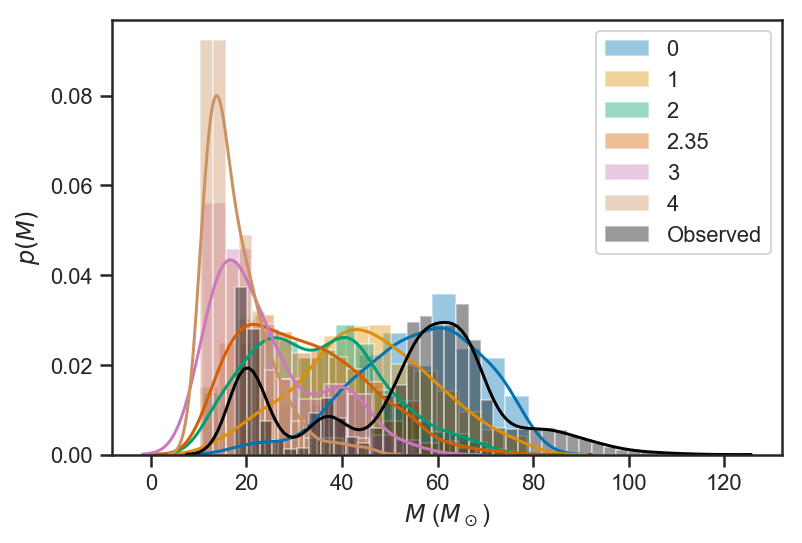

In [62]:
for k, c in clusters.items():
    sns.distplot(c['m1']+c['m2'], label=str(k))
    
ps = []
for _, p in postsamples.items():
    ps.append(random.choice(p[0]+p[1], size=1000))
ps = np.concatenate(ps)
sns.distplot(ps, color='k', label='Observed')

legend(loc='best')
xlabel(r'$M$ ($M_\odot$)')
ylabel(r'$p\left( M \right)$')

We want a way to check that the output of the models is reasonable.  We need to compare *observed* properties to predictions for the *observed* properties from the models.  Here is (one way) we can do this.

We choose to compare in the space of total mass.  We begin by drawing samples from the PE *likelihood* in total mass (i.e. we un-weight the PE samples from the prior).  Then we draw sets of 10 *detected* samples in total mass from each of the mass models; for each *detected* sample in total mass, we choose the likelihood whose median is closest to the total mass, and scatter the detected mass by the width of that likelihood function.  We plot the distributions so obtained against random draws from the likelihoods and compare.

In [66]:
Ndraw = 100

zs = expm1(linspace(log(1), log(1+zMax), 100))
pzs = Planck15.differential_comoving_volume(zs).to(u.Gpc**3/u.sr).value*(1+zs)**(lam-1)
pzs /= trapz(pzs, zs)
czs = cumtrapz(pzs, zs, initial=0)
izcdf = interp1d(czs, zs)
zcdf = interp1d(zs, czs)

snr_thresh = 8

mt_medians = array([median(p[0]+p[1]) for p in postsamples.values()])

cluster_weights = [1.0/p_pe(*p)/np.sum(1/p_pe(*p)) for p in postsamples.values()]

obs_draws = []
for i in tqdm_notebook(range(Ndraw)):
    draws = [random.choice(p[0]+p[1], p=wt) for p, wt in zip(postsamples.values(), cluster_weights)]
    obs_draws.append(draws)

Nc = len(clusters.values())
    
cluster_draws = []
for ic, (k, c) in tqdm_notebook(enumerate(clusters.items()), total=Nc, desc="Clusters"):
    mts = []
    for i in tqdm_notebook(range(Ndraw), desc="Draws from cluster {:g}".format(k)):
        mt_det = []
        while len(mt_det) < len(postsamples.values()):
            i = randint(len(c['m1']))
            m1 = c['m1'][i]
            m2 = c['m2'][i]
            z = izcdf(rand())

            rho = random.choice(vt.thetas)*optimal_snr(m1, m2, z) + randn()

            if rho > snr_thresh:
                mt_det.append(m1+m2)
        mt_obs = []
        for mt in mt_det:
            i = argmin(abs(mt_medians - mt))
            p = list(postsamples.values())[i]
            mt_obs.append(mt + random.choice(p[0]+p[1]) - random.choice(p[0]+p[1]))
        
        mts.append(mt_obs)
        
    cluster_draws.append(mts)

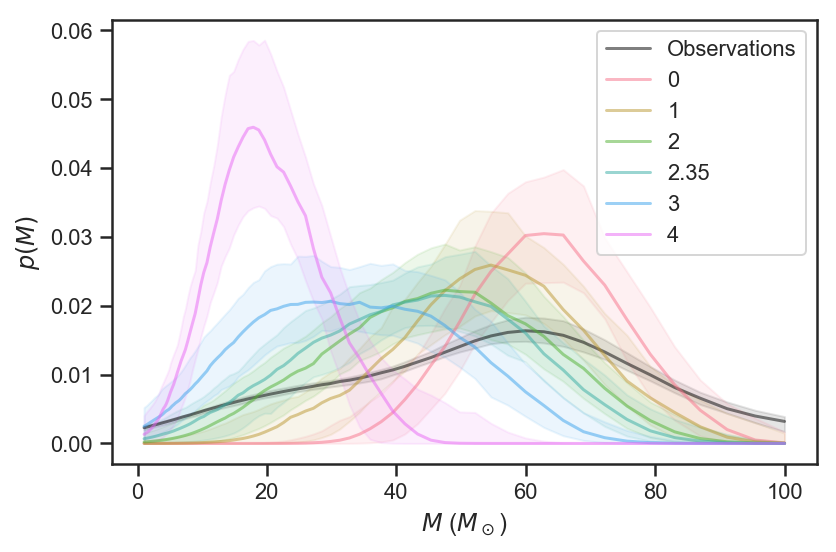

In [76]:
ms = exp(linspace(log(1), log(100), 100))

pal = sns.color_palette(palette='husl', n_colors=len(clusters))

obs_ps = []
for od in obs_draws:
    obs_ps.append(gaussian_kde(od)(ms))
obs_ps = array(obs_ps)

plot(ms, median(obs_ps, axis=0), color='k', label='Observations', alpha=0.5)
fill_between(ms, percentile(obs_ps, 84, axis=0), percentile(obs_ps, 16, axis=0), color='k', alpha=0.1)

for i, (k, cd) in enumerate(zip(clusters.keys(), cluster_draws)):
    cps = []
    for d in cd:
        cps.append(gaussian_kde(d)(ms))
    cps = array(cps)
    
    l, = plot(ms, median(cps, axis=0), label=str(k), alpha=0.5, color=pal[i])
    fill_between(ms, percentile(cps, 84, axis=0), percentile(cps, 16, axis=0), color=l.get_color(), alpha=0.1)
    
legend(loc='best')
xlabel(r'$M$ ($M_\odot$)')
ylabel(r'$p(M)$')

tight_layout()

savefig('M-pred.pdf')